In [2]:
import cv2
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, Polygon
from collections import defaultdict
from typing import List, Dict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from collections import deque
from utils import *

from sklearn.neighbors import KDTree

In [3]:
# Placeholder: Already implemented externally
def load_coco_inferences(coco_json_path: str) -> Dict[int, List[Dict]]:
    """
    Load inferenced COCO file and return a mapping from image_id to list of detections.

    Args:
        coco_json_path (str): Path to the COCO-format JSON file.

    Returns:
        Dict[int, List[Dict]]: Mapping from image_id to list of detection dicts.
    """
    import json

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Build mapping from image_id to image file name (if needed)
    image_id_to_filename = {img['id']: img['file_name'] for img in coco_data.get('images', [])}

    # Group annotations by image_id
    image_id_to_anns = defaultdict(list)
    for ann in coco_data.get('annotations', []):
        image_id_to_anns[ann['image_id']].append(ann)

    return dict(image_id_to_anns)


def project_ellipse_center_to_world(camera_meta: np.ndarray, ellipse_center_px: np.ndarray) -> Dict:
    """
    Project ellipse center in image to a ray in world coordinates.
    Returns {'origin': np.ndarray, 'direction': np.ndarray}
    """
    
    film_coords = spherical_unprojection(ellipse_center_px[0], ellipse_center_px[1], 1, camera_meta['width'], camera_meta['height'])
    x_local, y_local, z_local = transform_to_local_crs(film_coords[0], film_coords[1], film_coords[2], camera_meta)
    ray_vertex = np.array([x_local, y_local, z_local])

    cam_center = np.array([camera_meta['x'], camera_meta['y'], camera_meta['z']])
    ray_ori = ray_vertex - cam_center
    ray_data = {
        'origin': cam_center,
        'direction': ray_ori
    }
    return ray_data

def spatial_temporal_group_sort(
    gdf_grouped,
    time_column="gps_sec_s_",
    x_col="x_m_",
    y_col="y_m_",
    z_col="z_m_",
    radius=10.0,
    output_column="sort_index"
):
    """
    Two-stage spatial-temporal sort on groupby(image_id) object.
    
    Parameters:
        gdf_grouped: GroupBy object, grouped by 'image_id'.
        time_column (str): Column for GPS time (shared within each group).
        x_col, y_col, z_col (str): Position columns (shared within each group).
        radius (float): Search radius in meters.
        output_column (str): Name of output sort index column.
    
    Returns:
        GeoDataFrame: With new sort_index column.
        GroupBy: Sorted groupby object (ordered by sort_index).
    """

    # Step 1: Extract one row per group to represent its position and time
    group_meta = (
        gdf_grouped[[time_column, x_col, y_col, z_col]]
        .first()
        .reset_index()
    )

    # Sort groups by time (Stage 1)
    group_meta = group_meta.sort_values(by=time_column).reset_index(drop=True)
    positions = group_meta[[x_col, y_col, z_col]].values
    image_ids = group_meta["image_id"].values

    tree = KDTree(positions)
    used = np.zeros(len(group_meta), dtype=bool)
    final_order_indices = []

    prev_anchor_idx = None

    for current_anchor_idx in range(len(group_meta)):
        if used[current_anchor_idx]:
            continue

        current_pos = positions[current_anchor_idx]

        if prev_anchor_idx is None:
            group_indices = [current_anchor_idx]
        else:
            prev_pos = positions[prev_anchor_idx]
            direction = current_pos - prev_pos
            direction_norm = np.linalg.norm(direction)
            if direction_norm < 1e-6:
                direction = np.array([1, 0, 0])
            else:
                direction = direction / direction_norm

            neighbor_indices = tree.query_radius([current_pos], r=radius)[0]
            neighbor_indices = [i for i in neighbor_indices if not used[i]]

            if not neighbor_indices:
                continue

            neighbor_positions = positions[neighbor_indices]
            projections = neighbor_positions @ direction
            sorted_local = np.array(neighbor_indices)[np.argsort(projections)]
            group_indices = sorted_local.tolist()

        used[group_indices] = True
        final_order_indices.extend(group_indices)
        prev_anchor_idx = current_anchor_idx

    # Create mapping from image_id to sort index
    sort_index_map = {image_ids[idx]: i for i, idx in enumerate(final_order_indices)}

    # Apply mapping to original GeoDataFrame
    gdf_with_sort = gdf_grouped.obj.copy()
    gdf_with_sort[output_column] = gdf_with_sort["image_id"].map(sort_index_map)

    # Return new dataframe and sorted groupby object
    gdf_sorted = gdf_with_sort.sort_values(by=output_column)
    return gdf_sorted.groupby("image_id", sort=False)


In [4]:
def fit_ellipse_from_mask(mask: np.ndarray):
    """Fit an ellipse to a binary mask."""
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    ellipse = cv2.fitEllipse(cnt)
    return ellipse  # (center(x, y), (major, minor), angle)

class Ray():
    def __init__(self, origin: np.ndarray, direction: np.ndarray, frame_id: int, candidate_id=None):
        self.origin = origin
        self.direction = direction / np.linalg.norm(direction)
        self.frame_id = frame_id
        self.candidate_id = candidate_id  # which candidate this ray is currently associated with

# Intersection class definition
class Intersection:
    def __init__(self, point, ray_pair, dist, length):
        self.point = point          # np.array([x, y, z])
        self.ray_pair = ray_pair    # tuple of (prev_idx, new_idx)
        self.dist = dist            # float, distance between rays at intersection
        self.length = length        # float, sum of distances from ray origins to intersection

def compute_ray_intersection(ray1: Ray, ray2: Ray, radius: float = 10.0, distance_threshold: float = 0.5) -> np.ndarray:
    """
    Return intersection point if rays intersect in their forward direction and are close enough.
    Otherwise, return None.
    """
    p1, d1 = ray1.origin, ray1.direction
    p2, d2 = ray2.origin, ray2.direction

    v12 = p2 - p1
    d1_dot_d2 = np.dot(d1, d2)
    denom = 1 - d1_dot_d2 ** 2
    if abs(denom) < 1e-6:
        return None, None, None  # Nearly parallel, no intersection in forward direction
    t1 = (np.dot(v12, d1) - np.dot(v12, d2) * d1_dot_d2) / denom
    t2 = - (np.dot(v12, d2) - np.dot(v12, d1) * d1_dot_d2) / denom
    if t1 < 0 or t2 < 0 or t1 > radius or t2 > radius:
        return None, None, None # Closest approach is behind at least one ray's origin
    point1 = p1 + t1 * d1
    point2 = p2 + t2 * d2
    dist = np.linalg.norm(point1 - point2)

    if dist > distance_threshold:
        return None, None, None  # Closest points are too far apart to be considered an intersection
    
    intersect = (point1 + point2) / 2
    if intersect[2] >= min(p1[2], p2[2]) - 2.0 or intersect[2] <= min(p1[2], p2[2]) - 3.8:
        return None, None, None
    return intersect, dist, max(t1, t2)

def cluster_intersections(intersections: List[np.ndarray], distance_threshold: float = 0.5) -> List[List[int]]:
    """Cluster intersection points by spatial proximity using DBSCAN."""
    if len(intersections) == 0:
        return []
    X = np.stack(intersections)
    db = DBSCAN(eps=distance_threshold, min_samples=1).fit(X)
    labels = db.labels_
    clusters = []
    for label in set(labels):
        cluster = np.where(labels == label)[0].tolist()
        clusters.append(cluster)
    return clusters

def estimate_disc_geometry(intersection_points: List[np.ndarray]) -> Dict:
    """Initialize manhole model: center, upward normal, and radius."""
    center = np.mean(intersection_points, axis=0)
    normal = np.array([0, 0, 1])
    radius = 0.3  # fixed 30cm
    return {"center": center, "normal": normal, "radius": radius}

def detect_and_localize_manhole(gdf: gpd.GeoDataFrame, verbose=True) -> gpd.GeoDataFrame:
    """
    Detect and localize manholes from georeferenced mobile mapping imagery.
    Uses a list for rays, updates candidates incrementally, and manages candidate/ray lifecycle.
    """

    # Parameters
    intersection_distance_threshold = 0.5  # meters, for intersection and clustering
    candidate_update_threshold = 0.5       # meters, for candidate consistency
    candidate_missing_limit = 2            # number of consecutive frames without new rays before removal

    # State
    ray_list = []  # List of Ray objects
    candidate_list = []  # List of dicts: {'center', 'rays', 'last_seen', 'missing'}
    candidate_history = dict()

    # Group by image_id to get all annotations for each image
    grouped = gdf.groupby('image_id')

    if verbose:
        iterator = tqdm(grouped, total=len(grouped), desc="Processing frames")
    else:
        iterator = grouped

    for image_id, df_frame in iterator:
        frame_id = image_id
        
        camera_meta = {
            'x': df_frame.iloc[0]['x_m_'],
            'y': df_frame.iloc[0]['y_m_'],
            'z': df_frame.iloc[0]['z_m_'],
            'yaw': df_frame.iloc[0]['gpsimgdirection'],
            'pitch': df_frame.iloc[0]['gpspitch'],
            'roll': df_frame.iloc[0]['gpsroll'],
            'width': df_frame.iloc[0]['width'],
            'height': df_frame.iloc[0]['height']
        }

        # Get predicted masks for this image 
        new_rays = []
        for det in df_frame.geometry:
            # # Assume det['segmentation'] is a mask or can be converted to mask
            # mask = det.get('mask', None)
            # if mask is None and 'segmentation' in det:
            #     # If segmentation is polygon, convert to mask (requires image size)
            #     # Here, we skip for brevity; in practice, implement conversion
            #     continue
            # ellipse = fit_ellipse_from_mask(mask)
            # if ellipse is None:
            #     continue
            # center_px = np.array(ellipse[0])
            center_px = np.array(det.centroid.coords)[0]
            ray_data = project_ellipse_center_to_world(camera_meta, center_px)
            ray = Ray(ray_data['origin'], ray_data['direction'], frame_id)
            new_rays.append(ray)

        # Add new rays to the ray list
        ray_start_idx = len(ray_list)
        ray_list.extend(new_rays)
        new_ray_indices = np.arange(ray_start_idx, len(ray_list))

        # Compute intersections between all rays in the current list
        n_rays = len(ray_list)
        intersections = []
        ray_pairs = []

        # Use numpy for efficient index generation
        if n_rays > 1:
            idx_i, idx_j = np.triu_indices(n_rays, k=1)
            # Only consider pairs from different frames and within temporal proximity
            frame_ids = np.array([ray.frame_id for ray in ray_list])
            valid_mask = (frame_ids[idx_i] != frame_ids[idx_j]) & (np.abs(frame_ids[idx_i] - frame_ids[idx_j]) <= 5)
            idx_i = idx_i[valid_mask]
            idx_j = idx_j[valid_mask]

            # For each unique (frame_id_i, frame_id_j) pair, keep only the intersection with the shortest distance
            pair_to_best = dict()
            for i, j in zip(idx_i, idx_j):
                frame_pair = tuple(sorted((frame_ids[i], frame_ids[j])))
                pt, dist = compute_ray_intersection(ray_list[i], ray_list[j], distance_threshold=intersection_distance_threshold)
                if pt is not None:
                    if (frame_pair not in pair_to_best) or (dist < pair_to_best[frame_pair][1]):
                        pair_to_best[frame_pair] = ((pt, (i, j)), dist)
            for (pt, (i, j)), _ in pair_to_best.values():
                intersections.append(pt)
                ray_pairs.append((i, j))

        # Cluster intersections to get candidate manhole locations
        clusters = cluster_intersections(intersections, distance_threshold=intersection_distance_threshold)

        # For each cluster, compute center and associate rays
        new_candidates = []
        if len(clusters) > 0:
            intersections_np = np.array(intersections)
            for cluster in clusters:
                cluster_points = intersections_np[cluster]
                cluster_ray_indices = set()
                for i in cluster:
                    cluster_ray_indices.update(ray_pairs[i])
                center = np.mean(cluster_points, axis=0)
                new_candidates.append({'center': center, 'rays': cluster_ray_indices, 'last_seen': frame_id, 'missing': 0})

        # Update existing candidates or add new ones
        updated_candidate_ids = set()
        for nc in new_candidates:
            nc_center = nc['center']
            matched = False
            for cid, cand in enumerate(candidate_list):
                dist = np.linalg.norm(nc_center - cand['center'])
                if dist < candidate_update_threshold:
                    # Update candidate: average center, update rays, reset missing
                    total_rays = len(cand['rays']) + len(nc['rays'])
                    if total_rays > 0:
                        cand['center'] = (cand['center'] * len(cand['rays']) + nc_center * len(nc['rays'])) / total_rays
                    cand['rays'].update(nc['rays'])
                    cand['last_seen'] = frame_id
                    cand['missing'] = 0
                    updated_candidate_ids.add(cid)
                    candidate_history.setdefault(cid, []).append(cand['center'].copy())
                    matched = True
                    break
            if not matched:
                # New candidate
                candidate_list.append({'center': nc_center, 'rays': set(nc['rays']), 'last_seen': frame_id, 'missing': 0})
                new_cid = len(candidate_list) - 1
                updated_candidate_ids.add(new_cid)
                candidate_history.setdefault(new_cid, []).append(nc_center.copy())

        # For candidates not updated, increment missing count
        for cid, cand in enumerate(candidate_list):
            if cid not in updated_candidate_ids:
                cand['missing'] += 1

        # Remove candidates missing for more than candidate_missing_limit frames
        to_remove = []
        for cid, cand in enumerate(candidate_list):
            if cand['missing'] > candidate_missing_limit:
                # Remove all rays associated with this candidate from the ray queue
                rays_to_remove = cand['rays']
                # Mark rays for removal by index
                to_remove.append(cid)
                # Remove rays from ray_list by setting to None (to avoid index shift)
                for ridx in rays_to_remove:
                    if 0 <= ridx < len(ray_list):
                        ray_list[ridx] = None

        # Actually remove candidates
        for cid in sorted(to_remove, reverse=True):
            del candidate_list[cid]

        # Remove None rays from ray_list and update candidate ray indices
        if any(ray is None for ray in ray_list):
            old_to_new_idx = {}
            new_ray_list = []
            for i, ray in enumerate(ray_list):
                if ray is not None:
                    old_to_new_idx[i] = len(new_ray_list)
                    new_ray_list.append(ray)
            ray_list = new_ray_list
            # Update candidate ray indices
            for cand in candidate_list:
                cand['rays'] = set([old_to_new_idx[ridx] for ridx in cand['rays'] if ridx in old_to_new_idx])

    # After all frames, output remaining candidates as GeoDataFrame
    rows = []
    for cand in candidate_list:
        center = cand['center']
        geom = Point(center[0], center[1])
        row = {
            'coords': geom,
            'elevation': center[2],
            'radius': 0.3,
            'normal_x': 0,
            'normal_y': 0,
            'normal_z': 1
        }
        rows.append(row)

    out_gdf = gpd.GeoDataFrame(rows, geometry='coords', crs="epsg:2056")
    return out_gdf


# Trajectory & COCO

## GT


In [5]:
# Read the trajectory CSV as a DataFrame
traject = pd.read_csv('/mnt/Data/StreetView/data/neuchatel/ne_traject.csv')
coco_file_path = '/mnt/Data/StreetView/data/neuchatel/valid_ne_250626.json'


# Construct geometry from x_m_, y_m_, z_m_
traject['geometry'] = traject.apply(lambda row: Point(row['x_m_'], row['y_m_'], row['z_m_']), axis=1)
gdf = gpd.GeoDataFrame(traject, geometry='geometry', crs="epsg:2056")
gdf = gpd.GeoDataFrame(traject)

# Load COCO data
with open(coco_file_path, 'r') as f:
    coco_data = json.load(f)

# --- Match gdf with coco_data by file_name ---
# Build a DataFrame from coco_data['images']
coco_images_df = pd.DataFrame(coco_data['images'])
coco_images_df.id = coco_images_df.id.astype(int)

# Remove '.jpg' from coco file_name for matching
coco_images_df['file_name_no_ext'] = coco_images_df['file_name'].str.replace('.jpg', '', regex=False)

# If gdf has a column with file name (without extension), match on that
# Let's assume the column is 'file_name' in gdf (without .jpg)
# If not, adjust accordingly
if 'file_name' not in gdf.columns:
    raise ValueError("gdf must have a 'file_name' column to match with COCO images.")

# Merge gdf with coco_images_df to get the COCO image id
gdf = gdf.merge(
    coco_images_df[['id', 'file_name_no_ext', 'width', 'height']],
    left_on='file_name',
    right_on='file_name_no_ext',
    how='right'
)
gdf = gdf.rename(columns={'id': 'coco_image_id'})
gdf.drop(columns=['file_name_no_ext'], inplace=True)

# --- COCO annotation processing as before ---
# Prepare a list of annotation records
records = []
for ann in coco_data['annotations']:
    image_id = ann['image_id']
    segmentation = ann['segmentation'][0]

    coords = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
    geometry = Polygon(coords)
    records.append({
        'image_id': image_id,
        'category_id': ann.get('category_id', None),
        'geometry': geometry,
        'annotation_id': ann.get('id', None),
        'object_id': ann.get('object_id', None)
    })

# Create a GeoDataFrame
ann_gdf = gpd.GeoDataFrame(records, geometry='geometry', crs="epsg:2056")

# Merge gdf with ann_gdf to get prediction mask
gdf = gdf.merge(
    ann_gdf,
    left_on='coco_image_id',
    right_on='image_id',
    how='right'
)
gdf.drop(columns=['coco_image_id'], inplace=True)

grouped = spatial_temporal_group_sort(gdf.groupby('image_id'))



# Triangulation

In [6]:
coco_data['categories']

[{'id': 1, 'name': 'manhole', 'supercategory': 'none'}]

In [5]:
# Parameters
intersection_distance_threshold = 0.5  # meters, for intersection and clustering
candidate_update_threshold = 1.0       # meters, for candidate consistency
candidate_missing_limit = 5            # number of consecutive frames without new rays before removal
radius = 10.0

# State
ray_list = []  # List of Ray objects (never removed, indices are constant)
candidate_list = []  # List of dicts: {'center', 'intersections', 'mean_intersection_length', 'last_seen', 'missing', 'object_ids'}
intersection_objs = []  # List of Intersection objects

iterator = tqdm(grouped, total=len(grouped), desc="Processing frames")

# Maintain sets of active indices for rays, candidates, and intersections
active_ray_indices = set()
active_candidate_indices = set()
active_intersection_indices = set()


for image_id, df_frame in iterator:
    frame_id = image_id

    camera_meta = {
        'x': df_frame.iloc[0]['x_m_'],
        'y': df_frame.iloc[0]['y_m_'],
        'z': df_frame.iloc[0]['z_m_'],
        'yaw': df_frame.iloc[0]['gpsimgdirection'] + 0.5,
        'pitch': df_frame.iloc[0]['gpspitch'],
        'roll': df_frame.iloc[0]['gpsroll'] - 0.3,
        'width': df_frame.iloc[0]['width'],
        'height': df_frame.iloc[0]['height']
    }

    # Get predicted masks for this image 
    new_rays = []
    for _, det in df_frame.iterrows():
        center_px = np.array(det.geometry_y.centroid.coords)[0]
        ray_data = project_ellipse_center_to_world(camera_meta, center_px)
        ray = Ray(ray_data['origin'], ray_data['direction'], frame_id, det['object_id'])
        new_rays.append(ray)

    # Add new rays to the ray list
    ray_start_idx = len(ray_list)
    ray_list.extend(new_rays)
    new_ray_indices = np.arange(ray_start_idx, len(ray_list))

    # When new rays are added, mark their indices as active
    active_ray_indices.update(new_ray_indices)

    # Compute intersections only between new rays and previous active rays, but store all intersections globally
    n_prev_rays = ray_start_idx
    n_new_rays = len(new_rays)
    new_intersection_indices = []
    if n_prev_rays > 0 and n_new_rays > 0:
        # For each pair of frame_id, only keep the intersection with the lowest dist
        # Use a dict to store: key = (frame_id_prev, frame_id_new), value = (dist, Intersection)
        for new_idx, ray_new in zip(new_ray_indices, new_rays):
            best_intersections = dict()
            for prev_idx in active_ray_indices:
                ray_prev = ray_list[prev_idx]
                # Only consider pairs from different frames
                if ray_prev.frame_id != ray_new.frame_id:
                    pt, dist, length = compute_ray_intersection(ray_prev, ray_new, radius=radius, distance_threshold=intersection_distance_threshold)
                    if pt is not None:
                        # Sort frame_id order to avoid duplicates (frame_id_a, frame_id_b)
                        frame_pair = tuple(sorted([ray_prev.frame_id, ray_new.frame_id]))
                        if frame_pair not in best_intersections or dist < best_intersections[frame_pair].dist:
                            best_intersections[frame_pair] = Intersection(
                                point=pt,
                                ray_pair=(prev_idx, new_idx),
                                dist=dist,
                                length=length
                            )
            # After collecting, add only the best intersections for each frame pair
            for intersection in best_intersections.values():
                intersection_objs.append(intersection)
                new_intersection_indices.append(len(intersection_objs) - 1)
    # Add new intersections to active set
    active_intersection_indices.update(new_intersection_indices)

    # Cluster only active intersections
    if len(active_intersection_indices) > 0:
        intersection_points = [intersection_objs[i].point for i in active_intersection_indices]
        clusters = cluster_intersections(intersection_points, distance_threshold=intersection_distance_threshold)
        # clusters: list of lists of indices into intersection_points (not global intersection_objs)
        # Map cluster indices back to global intersection_objs indices
        clusters_global = []
        active_intersection_indices_list = list(active_intersection_indices)
        for cluster in clusters:
            clusters_global.append([active_intersection_indices_list[i] for i in cluster])
    else:
        clusters_global = []

    # For each cluster, use the 3 intersects with least length to calculate candidate
    new_candidates = []
    if len(clusters_global) > 0:
        for cluster in clusters_global:
            # cluster is a list of indices into intersection_objs (global indices)
            cand_inters = [intersection_objs[i] for i in cluster]
            # Sort by length
            cand_inters_with_idx = sorted(zip(cluster, cand_inters), key=lambda x: x[1].length)
            # Take up to 3 intersections (if less than 3, take all)
            top_k = min(3, len(cand_inters_with_idx))
            selected_inters = cand_inters_with_idx[:top_k]
            selected_points = np.array([inter[1].point for inter in selected_inters])
            selected_intersection_indices = set([inter[0] for inter in selected_inters])
            selected_lengths = [inter[1].length for inter in selected_inters]
            mean_intersection_length = float(np.mean(selected_lengths)) if selected_lengths else float('nan')
            # Find all ray indices involved in these intersections
            cluster_ray_indices = set()
            for inter in selected_inters:
                cluster_ray_indices.update(inter[1].ray_pair)
            # Compute center as mean of the selected points
            center = np.mean(selected_points, axis=0)
            # Aggregate object_ids from rays in this candidate
            object_ids = set()
            for ridx in cluster_ray_indices:
                if 0 <= ridx < len(ray_list):
                    ray = ray_list[ridx]
                    if hasattr(ray, 'candidate_id'):
                        object_ids.add(ray.candidate_id)
            new_candidates.append({
                'center': center,
                'intersections': set(selected_intersection_indices),
                'mean_intersection_length': mean_intersection_length,
                'last_seen': frame_id,
                'missing': 0,
                'object_ids': set(object_ids)
            })

    # Update existing candidates or add new ones (dynamic pool)
    updated_candidate_ids = set()
    # Only consider active candidates for matching
    active_candidate_indices_list = list(active_candidate_indices)
    for nc in new_candidates:
        nc_center = nc['center']
        nc_inters = nc['intersections']
        nc_mean_length = nc['mean_intersection_length']
        matched = False
        if len(active_candidate_indices) > 0:
            # Compute distances to all active candidates
            candidate_centers = np.array([candidate_list[cid]['center'] for cid in active_candidate_indices_list])
            dists = np.linalg.norm(candidate_centers - nc_center, axis=1)
            # Get indices of candidates within 20 meters
            within_radius_indices = np.where(dists < radius)[0]
            # Prepare list of (cid, cand) for those within 20 meters
            candidates_to_compare = [(active_candidate_indices_list[cid], candidate_list[active_candidate_indices_list[cid]]) for cid in within_radius_indices]
        else:
            candidates_to_compare = []
        for cid, cand in candidates_to_compare:
            dist = np.linalg.norm(nc_center - cand['center'])
            if dist != 0 and dist < candidate_update_threshold:
                # Update candidate: use the 3 least length intersections from the union of intersections
                combined_inters = cand['intersections'].union(nc_inters)
                # Only consider active intersections for updating
                relevant_inters = [
                    (i, intersection_objs[i])
                    for i in combined_inters
                    if i in active_intersection_indices
                ]
                if len(relevant_inters) > 0:
                    # Sort by length and take up to 3
                    relevant_inters_sorted = sorted(relevant_inters, key=lambda x: x[1].length)
                    top_k = min(3, len(relevant_inters_sorted))
                    selected_points = np.array([relevant_inters_sorted[i][1].point for i in range(top_k)])
                    selected_indices = set([relevant_inters_sorted[i][0] for i in range(top_k)])
                    selected_lengths = [relevant_inters_sorted[i][1].length for i in range(top_k)]
                    new_center = np.mean(selected_points, axis=0)
                    mean_intersection_length = float(np.mean(selected_lengths)) if selected_lengths else float('nan')
                    cand['center'] = new_center
                    cand['intersections'] = selected_indices
                    cand['mean_intersection_length'] = mean_intersection_length
                else:
                    # If no relevant intersections, just union the sets and keep previous mean
                    cand['intersections'] = combined_inters
                    # Optionally, recalculate mean_intersection_length if possible
                    lengths = [intersection_objs[i].length for i in combined_inters if i < len(intersection_objs)]
                    cand['mean_intersection_length'] = float(np.mean(lengths)) if lengths else float('nan')
                # Update object_ids
                cand['object_ids'].update(nc['object_ids'])
                cand['last_seen'] = frame_id
                cand['missing'] = 0
                updated_candidate_ids.add(cid)
                matched = True
                break
        if not matched:
            # New candidate
            candidate_list.append({
                'center': nc_center,
                'intersections': set(nc_inters),
                'mean_intersection_length': nc_mean_length,
                'last_seen': frame_id,
                'missing': 0,
                'object_ids': set(nc['object_ids'])
            })
            new_cid = len(candidate_list) - 1
            updated_candidate_ids.add(new_cid)
            active_candidate_indices.add(new_cid)

    # For candidates not updated, increment missing count
    for cid in list(active_candidate_indices):
        if cid not in updated_candidate_ids:
            cand = candidate_list[cid]
            cand['missing'] += 1
            # If missing count reaches threshold, deactivate all rays belonging to this candidate and deactivate candidate
            if cand['missing'] > candidate_missing_limit:
                # Deactivate all rays belonging to this candidate (find all rays in its intersections)
                rays_to_remove = set()
                for iid in cand['intersections']:
                    inter = intersection_objs[iid]
                    rays_to_remove.update(inter.ray_pair)
                active_ray_indices.difference_update(rays_to_remove)
                active_candidate_indices.discard(cid)
                # Also deactivate intersections that only involve rays from this candidate
                intersections_to_remove = set()
                for iid in list(active_intersection_indices):
                    inter = intersection_objs[iid]
                    if inter.ray_pair[0] in rays_to_remove or inter.ray_pair[1] in rays_to_remove:
                        intersections_to_remove.add(iid)
                active_intersection_indices.difference_update(intersections_to_remove)


# Prepare candidate centers for clustering
candidate_centers = np.array([cand['center'] for cand in candidate_list])
if len(candidate_centers) == 0:
    # No candidates to process
    pass
else:
    # Cluster with DBSCAN using intersection_distance_threshold as eps
    db = DBSCAN(eps=2*intersection_distance_threshold, min_samples=1)
    labels = db.fit_predict(candidate_centers)

    # Group candidate indices by cluster label
    from collections import defaultdict
    clusters = defaultdict(list)
    for idx, label in enumerate(labels):
        clusters[label].append(idx)

    new_candidate_list = []
    old_to_new_cid = {}

    for label, indices in tqdm(clusters.items()):
        if len(indices) == 1:
            # Keep singleton candidate as is
            orig_cid = indices[0]
            new_cid = len(new_candidate_list)
            new_candidate_list.append(candidate_list[orig_cid])
            old_to_new_cid[orig_cid] = new_cid
        else:
            # Merge candidates in this cluster
            merged_intersections = set()
            merged_object_ids = set()
            merged_last_seen = -1
            merged_missing = float('inf')
            for cid in indices:
                cand = candidate_list[cid]
                merged_intersections.update(cand['intersections'])
                merged_object_ids.update(cand.get('object_ids', []))
                merged_last_seen = max(merged_last_seen, cand['last_seen'])
                merged_missing = min(merged_missing, cand['missing'])
            # Collect all intersection points for these intersection indices
            intersection_points = []
            intersection_lengths = []
            for iid in merged_intersections:
                intersection_points.append(intersection_objs[iid].point)
                intersection_lengths.append(intersection_objs[iid].length)
            if intersection_points:
                # Use up to 3 shortest-length intersections for center and mean
                merged_inters_with_length = [(iid, intersection_objs[iid]) for iid in merged_intersections]
                merged_inters_with_length_sorted = sorted(merged_inters_with_length, key=lambda x: x[1].length)
                top_k = min(3, len(merged_inters_with_length_sorted))
                selected_points = np.array([merged_inters_with_length_sorted[i][1].point for i in range(top_k)])
                selected_indices = set([merged_inters_with_length_sorted[i][0] for i in range(top_k)])
                selected_lengths = [merged_inters_with_length_sorted[i][1].length for i in range(top_k)]
                new_center = np.mean(selected_points, axis=0)
                mean_intersection_length = float(np.mean(selected_lengths)) if selected_lengths else float('nan')
                new_intersections = selected_indices
            else:
                # Fallback: mean of original centers
                centers = [candidate_list[k]['center'] for k in indices]
                new_center = np.mean(np.array(centers), axis=0)
                mean_intersection_length = float('nan')
                new_intersections = set()
            new_cand = {
                'center': new_center,
                'intersections': new_intersections if new_intersections else merged_intersections,
                'mean_intersection_length': mean_intersection_length,
                'last_seen': merged_last_seen,
                'missing': merged_missing,
                'object_ids': merged_object_ids
            }
            new_cid = len(new_candidate_list)
            for k in indices:
                old_to_new_cid[k] = new_cid
            new_candidate_list.append(new_cand)

    # Replace candidate_list with merged version
    candidate_list = new_candidate_list

    # Update active_candidate_indices to new indices
    active_candidate_indices = set(old_to_new_cid[cid] for cid in active_candidate_indices if cid in old_to_new_cid)

100%|██████████| 1313/1313 [00:00<00:00, 25944.80it/s]


In [8]:
# Output remaining active candidates as GeoDataFrame (updated for new candidate object structure)
rows = []
for cid, cand in enumerate(candidate_list):
    center = cand['center']
    geom = Point(center[0], center[1])
    object_ids_set = set(cand.get('object_ids', []))
    intersections_set = set(cand.get('intersections', []))
    mean_intersection_length = cand.get('mean_intersection_length', float('nan'))
    if mean_intersection_length >= 15:
        continue
    row = {
        'elevation': center[2],
        'radius': 0.3,
        'normal_x': 0,
        'normal_y': 0,
        'normal_z': 1,
        'object_ids': next(iter(object_ids_set)) if len(object_ids_set) == 1 else None,
        'object_ids_set': object_ids_set,
        'intersections': intersections_set,
        'mean_intersection_length': mean_intersection_length,
        'geometry': geom
    }
    rows.append(row)

out_gdf = gpd.GeoDataFrame(rows, geometry='geometry', crs="epsg:2056")
out_gdf.to_file(f"triangulation_points_test_{str(int(radius))+'m'}.gpkg", driver="GPKG")

In [23]:
len(candidate_list)

1917

In [8]:
len(active_ray_indices)

978

In [42]:
idx = 10000
ray_list[idx].origin, ray_list[idx].direction

(array([2.53240517e+06, 1.19338325e+06, 7.73620000e+02]),
 array([-0.93127414,  0.32141823, -0.17151909]))

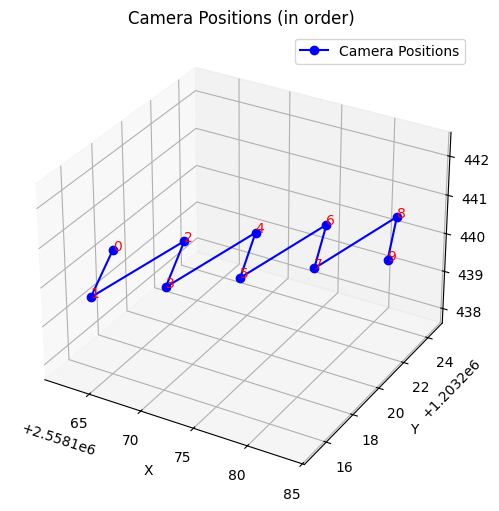

In [ ]:
import matplotlib.pyplot as plt

if len(camera_positions) > 0:
    camera_positions_np = np.array(camera_positions)[100:110]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    xs = camera_positions_np[:, 0]
    ys = camera_positions_np[:, 1]
    zs = camera_positions_np[:, 2]
    ax.plot(xs, ys, zs, marker='o', linestyle='-', color='blue', label='Camera Positions')
    for idx, (x, y, z) in enumerate(camera_positions_np):
        ax.text(x, y, z, str(idx), color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Positions (in order)')
    ax.legend()
    # Set z axis scale to 5 meters
    z_min = np.min(zs)
    z_max = np.max(zs)
    z_center = (z_min + z_max) / 2
    ax.set_zlim(z_center - 2.5, z_center + 2.5)
    plt.show()


# Metrics

In [7]:
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd


gt_path = '/mnt/Data/StreetView/data/neuchatel/NE_GT_3D.gpkg'
gt_gdf = gpd.read_file(gt_path, layer='ne_gt_3d')

pred_path = '/mnt/Data/StreetView/scripts/triangulation_points_test_10m.gpkg'
pred_gdf = gpd.read_file(pred_path)
# Helper: parse object_ids column to set of ints
def parse_object_ids(obj):
    if isinstance(obj, str):
        # Handles strings like '{492,493}' or '{1042}' or '{}'
        obj = obj.strip()
        if obj.startswith('{') and obj.endswith('}'):
            obj = obj[1:-1]
        return set(int(x) for x in obj.split(',') if x.strip())
    elif isinstance(obj, (list, set, tuple, np.ndarray)):
        return set(int(x) for x in obj)
    else:
        return set()

# Add parsed object_ids as a new column
pred_gdf = pred_gdf.copy()
pred_gdf['object_ids'] = pred_gdf['object_ids_set'].apply(parse_object_ids)

# True Positives: only one object_id, and it matches a gt_gdf fid
tp_rows = []
distances = []

for idx, row in pred_gdf.iterrows():
    obj_ids = row['object_ids']
    if len(obj_ids) == 1:
        obj_id = list(obj_ids)[0]
        gt_match = gt_gdf.iloc[obj_id]
        if not gt_match.empty:
            # True positive
            tp_rows.append(idx)
            # Calculate XY distance between pred point and gt polygon centroid
            pred_point = row['geometry']
            gt_poly = gt_match['geometry']
            gt_centroid = gt_poly.centroid
            # Only XY
            pred_xy = np.array([pred_point.x, pred_point.y])
            gt_xy = np.array([gt_centroid.x, gt_centroid.y])
            dist = np.linalg.norm(pred_xy - gt_xy)
            distances.append(dist)

# False Positives: more than one object_id in object_ids
fp_rows = pred_gdf[pred_gdf['object_ids'].apply(lambda s: len(s) > 1)].index.tolist()

# False Negatives: gt_gdf fids that are not detected as true positives
matched_gt_fids = set([list(pred_gdf.loc[i, 'object_ids'])[0] for i in tp_rows])
all_gt_fids = set(np.unique(gdf.object_id.values))
fn_fids = all_gt_fids - matched_gt_fids

# Metrics
TP = len(tp_rows)
FP = len(fp_rows)
FN = len(fn_fids)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Distance statistics
if distances:
    distances_np = np.array(distances)
    dist_stats = {
        'mean': np.mean(distances_np),
        'std': np.std(distances_np),
        'min': np.min(distances_np),
        'max': np.max(distances_np),
        'median': np.median(distances_np),
        'count': len(distances_np)
    }
else:
    dist_stats = {}

print("True Positives:", TP)
print("False Positives:", FP)
print("False Negatives:", FN)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("Distance statistics (meters) between predicted point and GT polygon centroid in XY plane:")
for k, v in dist_stats.items():
    print(f"  {k}: {v}")


True Positives: 1059
False Positives: 254
False Negatives: 274
Precision: 0.807
Recall: 0.794
Distance statistics (meters) between predicted point and GT polygon centroid in XY plane:
  mean: 0.06688686038057139
  std: 0.15446901317117126
  min: 0.0007250782595907663
  max: 2.4243456188398245
  median: 0.04611139701718896
  count: 1059


### 20M

In [ ]:
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd


gt_path = '/mnt/Data/StreetView/data/neuchatel/NE_GT_3D.gpkg'
gt_gdf = gpd.read_file(gt_path, layer='ne_gt_3d')

pred_path = '/mnt/Data/StreetView/scripts/triangulation_points_test_20m.gpkg'
pred_gdf = gpd.read_file(pred_path)
# Helper: parse object_ids column to set of ints
def parse_object_ids(obj):
    if isinstance(obj, str):
        # Handles strings like '{492,493}' or '{1042}' or '{}'
        obj = obj.strip()
        if obj.startswith('{') and obj.endswith('}'):
            obj = obj[1:-1]
        return set(int(x) for x in obj.split(',') if x.strip())
    elif isinstance(obj, (list, set, tuple, np.ndarray)):
        return set(int(x) for x in obj)
    else:
        return set()

# Add parsed object_ids as a new column
pred_gdf = pred_gdf.copy()
pred_gdf['object_ids'] = pred_gdf['object_ids_set'].apply(parse_object_ids)

# True Positives: only one object_id, and it matches a gt_gdf fid
tp_rows = []
distances = []

for idx, row in pred_gdf.iterrows():
    obj_ids = row['object_ids']
    if len(obj_ids) == 1:
        obj_id = list(obj_ids)[0]
        gt_match = gt_gdf.iloc[obj_id]
        if not gt_match.empty:
            # True positive
            tp_rows.append(idx)
            # Calculate XY distance between pred point and gt polygon centroid
            pred_point = row['geometry']
            gt_poly = gt_match['geometry']
            gt_centroid = gt_poly.centroid
            # Only XY
            pred_xy = np.array([pred_point.x, pred_point.y])
            gt_xy = np.array([gt_centroid.x, gt_centroid.y])
            dist = np.linalg.norm(pred_xy - gt_xy)
            distances.append(dist)

# False Positives: more than one object_id in object_ids
fp_rows = pred_gdf[pred_gdf['object_ids'].apply(lambda s: len(s) > 1)].index.tolist()

# False Negatives: gt_gdf fids that are not detected as true positives
matched_gt_fids = set([list(pred_gdf.loc[i, 'object_ids'])[0] for i in tp_rows])
all_gt_fids = set(np.unique(gdf.object_id.values))
fn_fids = all_gt_fids - matched_gt_fids

# Metrics
TP = len(tp_rows)
FP = len(fp_rows)
FN = len(fn_fids)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Distance statistics
if distances:
    distances_np = np.array(distances)
    dist_stats = {
        'mean': np.mean(distances_np),
        'std': np.std(distances_np),
        'min': np.min(distances_np),
        'max': np.max(distances_np),
        'median': np.median(distances_np),
        'count': len(distances_np)
    }
else:
    dist_stats = {}

print("True Positives:", TP)
print("False Positives:", FP)
print("False Negatives:", FN)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("Distance statistics (meters) between predicted point and GT polygon centroid in XY plane:")
for k, v in dist_stats.items():
    print(f"  {k}: {v}")


True Positives: 1134
False Positives: 343
False Negatives: 232
Precision: 0.768
Recall: 0.830
Distance statistics (meters) between predicted point and GT polygon centroid in XY plane:
  mean: 0.12419167032816962
  std: 0.3923093651824855
  min: 0.0007250782595907663
  max: 5.307617557698561
  median: 0.04993786066454768
  count: 1134


In [56]:
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd


gt_path = '/mnt/Data/StreetView/data/neuchatel/NE_GT_3D.gpkg'
gt_gdf = gpd.read_file(gt_path, layer='ne_gt_3d')

pred_path = '/mnt/Data/StreetView/scripts/triangulation_points_test_20m.gpkg'
pred_gdf = gpd.read_file(pred_path)
# Helper: parse object_ids column to set of ints
def parse_object_ids(obj):
    if isinstance(obj, str):
        # Handles strings like '{492,493}' or '{1042}' or '{}'
        obj = obj.strip()
        if obj.startswith('{') and obj.endswith('}'):
            obj = obj[1:-1]
        return set(int(x) for x in obj.split(',') if x.strip())
    elif isinstance(obj, (list, set, tuple, np.ndarray)):
        return set(int(x) for x in obj)
    else:
        return set()

# Add parsed object_ids as a new column
pred_gdf = pred_gdf.copy()
pred_gdf['object_ids'] = pred_gdf['object_ids_set'].apply(parse_object_ids)

# True Positives: only one object_id, and it matches a gt_gdf fid
tp_rows = []
distances = []

for idx, row in pred_gdf.iterrows():
    obj_ids = row['object_ids']
    if len(obj_ids) == 1:
        obj_id = list(obj_ids)[0]
        gt_match = gt_gdf.iloc[obj_id]
        if not gt_match.empty:
            # True positive
            tp_rows.append(idx)
            # Calculate XY distance between pred point and gt polygon centroid
            pred_point = row['geometry']
            gt_poly = gt_match['geometry']
            gt_centroid = gt_poly.centroid
            # Only XY
            pred_xy = np.array([pred_point.x, pred_point.y])
            gt_xy = np.array([gt_centroid.x, gt_centroid.y])
            dist = np.linalg.norm(pred_xy - gt_xy)
            distances.append(dist)

# False Positives: more than one object_id in object_ids
fp_rows = pred_gdf[pred_gdf['object_ids'].apply(lambda s: len(s) > 1)].index.tolist()

# False Negatives: gt_gdf fids that are not detected as true positives
matched_gt_fids = set([list(pred_gdf.loc[i, 'object_ids'])[0] for i in tp_rows])
all_gt_fids = set(np.unique(gdf.object_id.values))
fn_fids = all_gt_fids - matched_gt_fids

# Metrics
TP = len(tp_rows)
FP = len(fp_rows)
FN = len(fn_fids)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Distance statistics
if distances:
    distances_np = np.array(distances)
    dist_stats = {
        'mean': np.mean(distances_np),
        'std': np.std(distances_np),
        'min': np.min(distances_np),
        'max': np.max(distances_np),
        'median': np.median(distances_np),
        'count': len(distances_np)
    }
else:
    dist_stats = {}

print("True Positives:", TP)
print("False Positives:", FP)
print("False Negatives:", FN)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("Distance statistics (meters) between predicted point and GT polygon centroid in XY plane:")
for k, v in dist_stats.items():
    print(f"  {k}: {v}")


True Positives: 1278
False Positives: 639
False Negatives: 176
Precision: 0.667
Recall: 0.879
Distance statistics (meters) between predicted point and GT polygon centroid in XY plane:
  mean: 0.22967834158152037
  std: 0.574516808158368
  min: 0.0007250782595907663
  max: 5.307617557698561
  median: 0.054257041340792095
  count: 1278
